In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
import pickle
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import pdb
from glob import glob
from neurosim.models.ssr import StateSpaceRealization as SSR
import sys

In [18]:
sys.path.append('../..')

In [19]:
from utils import apply_df_filters

In [4]:
# Consolidate
rfiles = glob('/home/akumar/nse/neural_control/mpi_test/*.dat')

In [5]:
master_list = []
for file in rfiles:
    with open(file, 'rb') as f:
        results = pickle.load(f)
        master_list.append(results)

In [8]:
result_df = pd.DataFrame(master_list)

In [10]:
result_df.keys()

Index(['fold_idx', 'N', 'trajectory_rep', 'model_rep', 'true_params',
       'autocorr_true', 'autocorr_train', 'autocorr_test', 'model_order',
       'ssid_coef', 'MLcoef', 'coef'],
      dtype='object')

In [12]:
# Key thing to test: What is the cross-validated error in estimation of the cross correlation matrices?
N = np.unique(result_df['N'].values)
trajectory_rep = np.unique(result_df['trajectory_rep'].values)
model_order = np.unique(result_df['model_order'].values)

In [36]:
ssid_error1 = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))
ssid_error2 = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))
stable_em_error = np.zeros((N.size, trajectory_rep.size, model_order.size, 5, 5))

In [32]:
def autocorrelation1(A, C, Q, R, S, T):

    autocorr = np.zeros((T, C.shape[0], C.shape[0]))

    P = scipy.linalg.solve_discrete_lyapunov(A, Q)

    autocorr[0, ...] = C @ P @ C.T + R

    # Construct Cbar from A, P, C, and S
    Cbar = C @ P @ A.T + S.T

    for i in range(1, T):
        autocorr[i, ...] = C @ np.linalg.matrix_power(A, i - 1) @ Cbar.T
    return autocorr 


In [33]:
def autocorrelation2(A, C, Cbar, Q, R, T):

    autocorr = np.zeros((T, C.shape[0], C.shape[0]))

    P = scipy.linalg.solve_discrete_lyapunov(A, Q)

    autocorr[0, ...] = C @ P @ C.T + R

    for i in range(1, T):
        autocorr[i, ...] = C @ np.linalg.matrix_power(A, i - 1) @ Cbar.T
    return autocorr 

In [43]:
for i, n in enumerate(N):
    for j in trajectory_rep:
        for k, order in enumerate(model_order):
            df_ = apply_df_filters(result_df, N=n, trajectory_rep=j, model_order=order)
            for fold_idx in range(5):
                ssid_params = df_.iloc[fold_idx]['ssid_coef']
                ml_params = df_.iloc[fold_idx]['MLcoef']

                ccm_ssid1 = autocorrelation1(ssid_params[0], ssid_params[1], ssid_params[4], ssid_params[5], ssid_params[6], 5)
                ccm_ssid2 = autocorrelation2(ssid_params[0], ssid_params[1], ssid_params[2], ssid_params[4], ssid_params[5], 5)

                ccm_test = df_.iloc[fold_idx]['autocorr_test']
                ssid_error1[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_ssid1[idx]) for idx in range(5)]
                ssid_error2[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_ssid2[idx]) for idx in range(5)]


                if type(ml_params) == tuple:
                    ccm_ml = autocorrelation1(ml_params[0], ml_params[1], np.eye(ml_params[0].shape[0]), ml_params[2], np.zeros((ml_params[0].shape[0], ml_params[1].shape[0])), 5)
                    stable_em_error[i, j, k, fold_idx, :] = [np.linalg.norm(ccm_test[idx] - ccm_ml[idx]) for idx in range(5)]
                else:
                    stable_em_error[i, j, k, fold_idx, :] = np.nan


/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


In [44]:
model_order

array([15, 17, 19, 21, 23, 25])

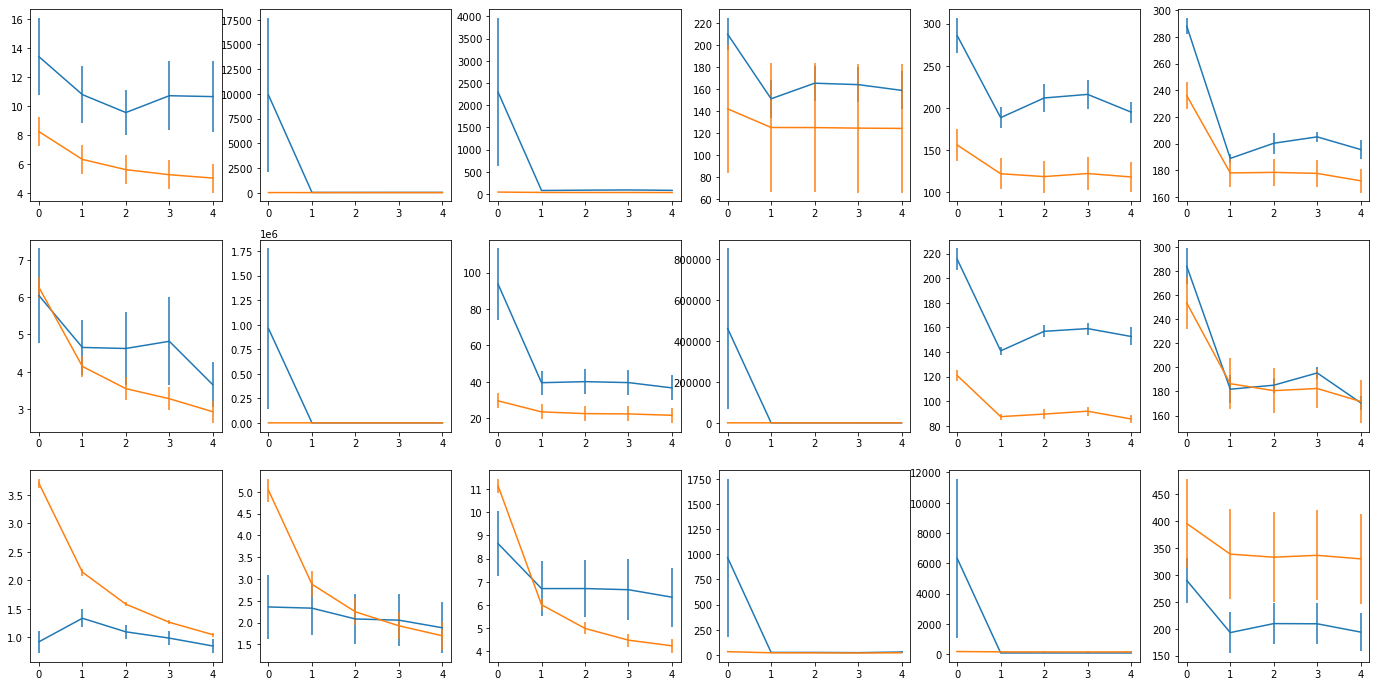

In [48]:
# Plots 

# Average cross folds. Each subplot is for a different N anbd model_order combination
fig, ax = plt.subplots(N.size, model_order.size, figsize=(4*model_order.size, 4*N.size))
for i in range(N.size):
    for j in range(model_order.size):
        # y1 = np.nanmean(np.nanmean(ssid_error1[i, :, j, ...], axis=0), axis=0)
        # y1st = np.nanstd(np.nanstd(ssid_error1[i, :, j, ...], axis=0), axis=0)/np.sqrt(50)

        y2 = np.nanmean(np.nanmean(ssid_error2[i, :, j, ...], axis=0), axis=0)
        y2st = np.nanstd(np.nanstd(ssid_error2[i, :, j, ...], axis=0), axis=0)/np.sqrt(50)

        y3 = np.nanmean(np.nanmean(stable_em_error[i, :, j, ...], axis=0), axis=0)
        y3st = np.nanstd(np.nanstd(stable_em_error[i, :, j, ...], axis=0), axis=0)/np.sqrt(50)

        # ax[i, j].errorbar(np.arange(5), y1, yerr=y1st)
        ax[i, j].errorbar(np.arange(5), y2, yerr=y2st)
        ax[i, j].errorbar(np.arange(5), y3, yerr=y3st)


In [46]:
# Need to get the analgous plots for VAR models

In [ ]:
# Then, show that running EM can reduce the 